In [7]:
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from interpretability_utils import *
from model_utils import split_data, train_model, oversample
from performance_plots_utils import plot_confusion_matrix, plot_metrics, plot_roc_curve
import tpot
from sklearn.model_selection import RepeatedStratifiedKFold

## Model
We focus on the Macro F1 Score as accuracy is not really relevant due to the imbalanced classes.

### Model generation

In [8]:
X_train, X_test, y_train, y_test = split_data('dataproject2022.csv', test_size=0.15)

model, X_train_oversampled, y_train_oversampled = train_model(RandomForestClassifier, X_train, y_train, oversample_method=SVMSMOTE, sampling_strategy=0.55)
predictions_tuned = model.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(predictions_tuned, y_test))

Training Features Shape: (6324, 10)
Training Labels Shape: (6324,)
Testing Features Shape: (1116, 10)
Testing Labels Shape: (1116,)
Features shape: (6324, 10)
Labels shape: (6324,)
Features oversampled shape: (7841, 10)
Labels oversampled shape: (7841,)
Accuracy: 0.791


### Model tuning

In [9]:
param_grid = {
              'n_estimators': [50, 100,200, 500, 1000],
              'max_features': ['auto', 'sqrt', 'log2', None, 0.2],
              'max_depth' : [None, 4,5,6,7,8, 20],
              'criterion' :['gini', 'entropy'],
              "max_samples" : [None, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
            }
search = HalvingRandomSearchCV(model, param_grid,random_state=0, n_candidates=40).fit(X_train_oversampled, y_train_oversampled)
search.best_params_ 

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

{'n_estimators': 1000,
 'max_samples': None,
 'max_features': None,
 'max_depth': None,
 'criterion': 'gini'}

In [11]:
model, X_train_oversampled, y_train_oversampled = train_model(RandomForestClassifier, X_train, y_train, oversample_method=SVMSMOTE, sampling_strategy=0.55, best_params=search.best_params_ )
predictions_tuned = model.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(predictions_tuned, y_test))

Features shape: (6324, 10)
Labels shape: (6324,)
Features oversampled shape: (7841, 10)
Labels oversampled shape: (7841,)
Accuracy: 0.795


### Model performance

In [12]:
plot_metrics(model, X_test, y_test)

Accuracy : 0.795
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       893
           1       0.48      0.32      0.39       223

    accuracy                           0.79      1116
   macro avg       0.66      0.62      0.63      1116
weighted avg       0.77      0.79      0.78      1116



[815.  78.]
[151.  72.]


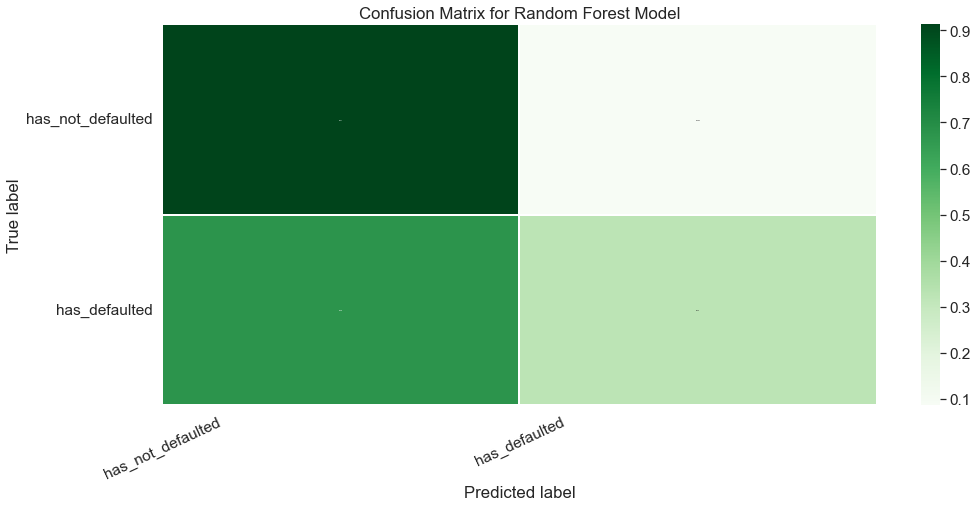

In [13]:
plot_confusion_matrix(model, X_test, y_test)

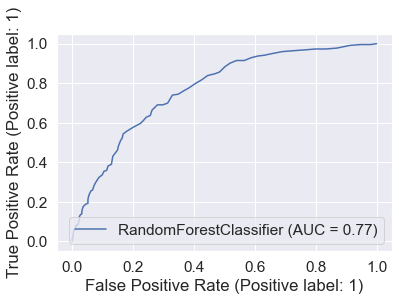

In [14]:
plot_roc_curve(model, X_test, y_test)

## Auto ML model

In [17]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
automl_model = tpot.TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='f1_macro', verbosity=2, random_state=1, n_jobs=-1)
automl_model.fit(X_train_oversampled, y_train_oversampled)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is n


Generation 1 - Current best internal CV score: 0.8045195363339049


/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 2 - Current best internal CV score: 0.8045195363339049

Generation 3 - Current best internal CV score: 0.8045195363339049


/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 4 - Current best internal CV score: 0.8073677821222823


/opt/homebrew/anaconda3/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 5 - Current best internal CV score: 0.8073677821222823

Best pipeline: GradientBoostingClassifier(VarianceThreshold(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), threshold=0.01), learning_rate=0.1, max_depth=9, max_features=0.8500000000000001, min_samples_leaf=8, min_samples_split=16, n_estimators=100, subsample=1.0)


TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
               generations=5, n_jobs=-1, population_size=50, random_state=1,
               scoring='f1_macro', verbosity=2)

### Model performance

In [18]:
plot_metrics(automl_model, X_test, y_test)

Accuracy : 0.789
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       893
           1       0.47      0.37      0.41       223

    accuracy                           0.79      1116
   macro avg       0.66      0.63      0.64      1116
weighted avg       0.77      0.79      0.78      1116



[799.  94.]
[141.  82.]


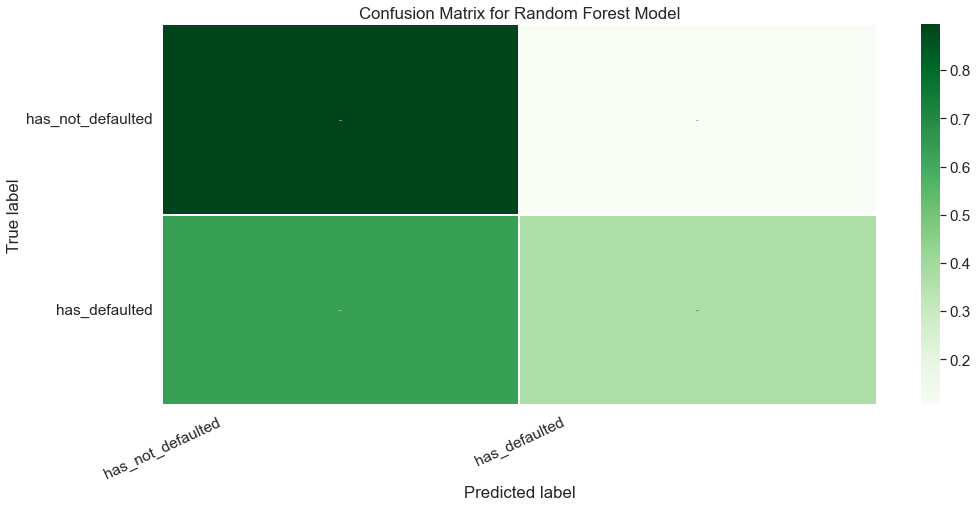

In [19]:
plot_confusion_matrix(automl_model, X_test, y_test)

## Global surrogate

In [15]:
new_target = model.predict(X_train)

surrogate_model = DecisionTreeClassifier(max_depth=4)
surrogate_model.fit(X_train, new_target)

DecisionTreeClassifier(max_depth=4)

[Text(0.5, 0.9, 'Job tenure <= 3.5\ngini = 0.32\nsamples = 6324\nvalue = [5059, 1265]'),
 Text(0.25, 0.7, 'Homeowner <= 0.5\ngini = 0.423\nsamples = 2516\nvalue = [1753, 763]'),
 Text(0.125, 0.5, 'Funding amount <= 18230.0\ngini = 0.458\nsamples = 1894\nvalue = [1221, 673]'),
 Text(0.0625, 0.3, 'Loan duration <= 48.5\ngini = 0.431\nsamples = 1576\nvalue = [1081, 495]'),
 Text(0.03125, 0.1, 'gini = 0.359\nsamples = 649\nvalue = [497, 152]'),
 Text(0.09375, 0.1, 'gini = 0.466\nsamples = 927\nvalue = [584, 343]'),
 Text(0.1875, 0.3, 'Age <= 22.5\ngini = 0.493\nsamples = 318\nvalue = [140, 178]'),
 Text(0.15625, 0.1, 'gini = 0.391\nsamples = 75\nvalue = [20, 55]'),
 Text(0.21875, 0.1, 'gini = 0.5\nsamples = 243\nvalue = [120, 123]'),
 Text(0.375, 0.5, 'Married <= 0.5\ngini = 0.248\nsamples = 622\nvalue = [532, 90]'),
 Text(0.3125, 0.3, 'Funding amount <= 14403.5\ngini = 0.393\nsamples = 190\nvalue = [139, 51]'),
 Text(0.28125, 0.1, 'gini = 0.32\nsamples = 135\nvalue = [108, 27]'),
 Text(0.

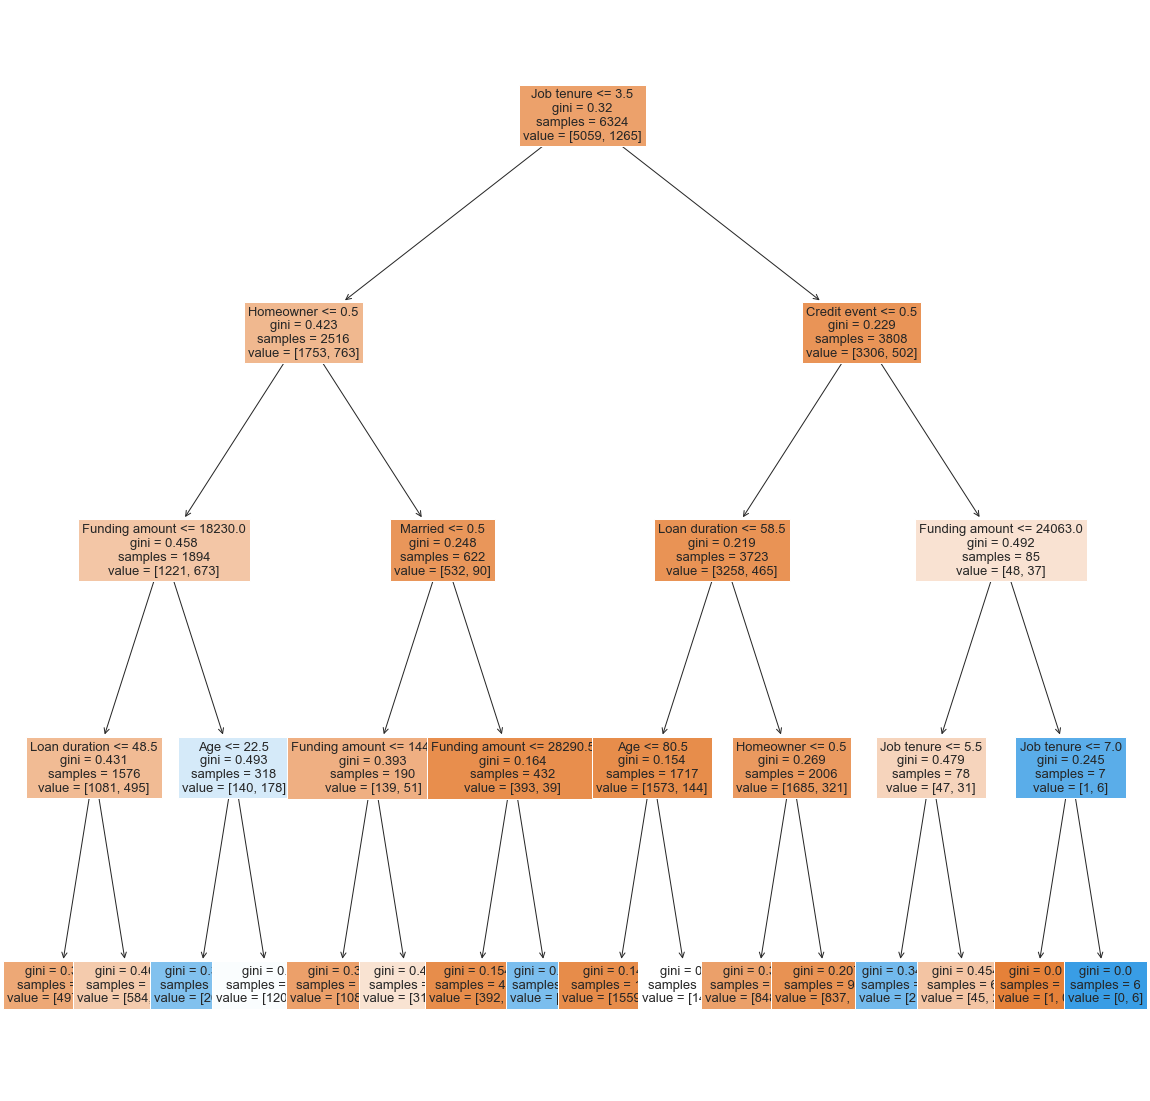

In [16]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(20,20)) # Resize figure
tree.plot_tree(surrogate_model, filled=True, ax=ax, fontsize=13, feature_names=X_train.columns)
# plt.savefig('tree_high_dpi', dpi=100)

In [17]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = surrogate_model.feature_importances_
feature_importance.sort_values(by="importance", ascending=False)

px.bar(feature_importance, "importance","feature").update_xaxes(categoryorder='min ascending', title="Feature importance for decision tree classifier surrogate model on our blackbox model")

# Global Interpretability

### PDP 
The Partial Dependence Plot (PDP) shows the marginal effect one feature has on the predicted outcome of a machine learning model (Friedman 2001).

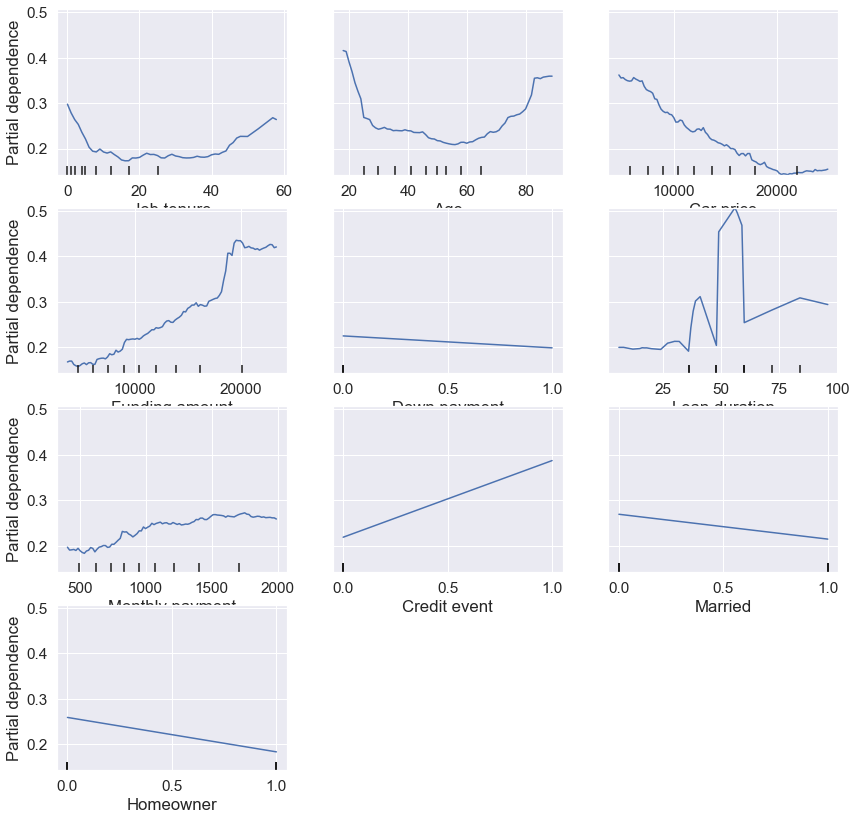

In [18]:
plot_pdp(X_train, model)

#### Interpretation of the PDP : 
- Job tenure

### ICE

Individual Conditional Expectation (ICE) plots display one curve per instance 
    that shows how the instance’s prediction changes when a feature changes.

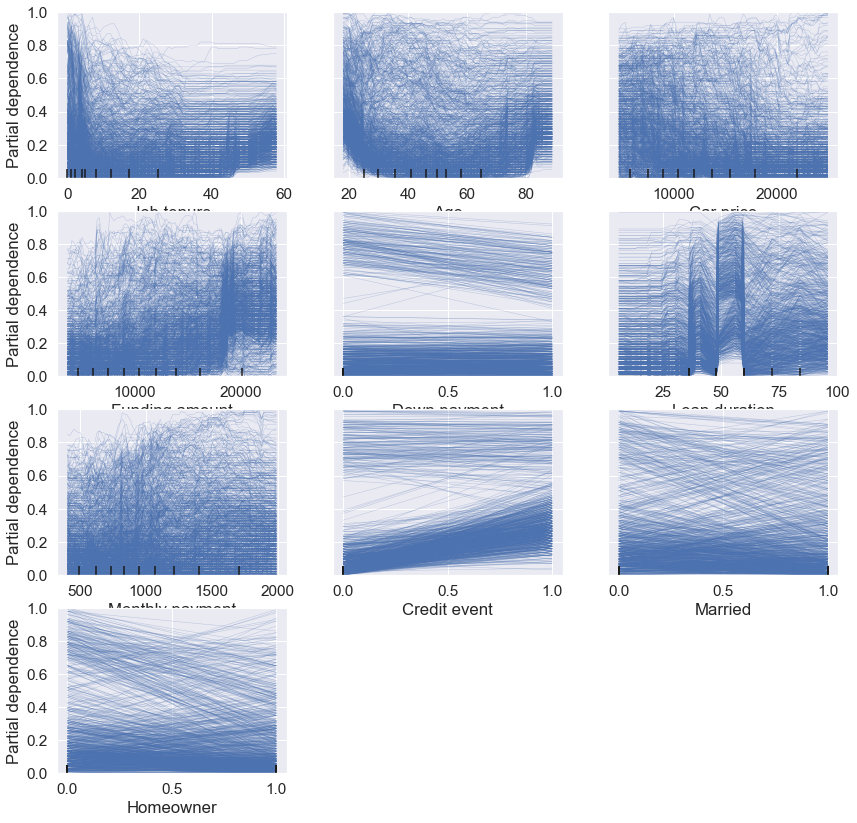

In [19]:
plot_ice(X_train, model)

#### Interpretation of the ICE : 
- Job tenure... 

### ALE

Accumulated Local Effects (ALE) plots describe how features influence 
    the prediction of a ML model on average, while taking into account the 
    dependence between the features.

ALE solves the combined-effect problem by calculating differences in predictions instead
of averages, yet using conditional distributions.

PyALE._ALE_generic:INFO: Continuous feature detected.


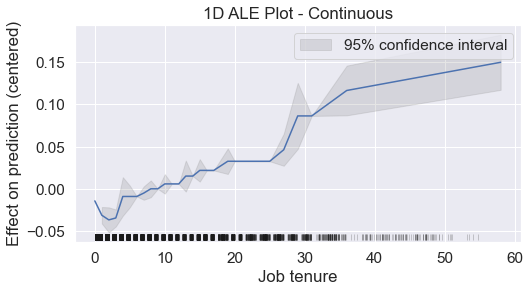

PyALE._ALE_generic:INFO: Continuous feature detected.


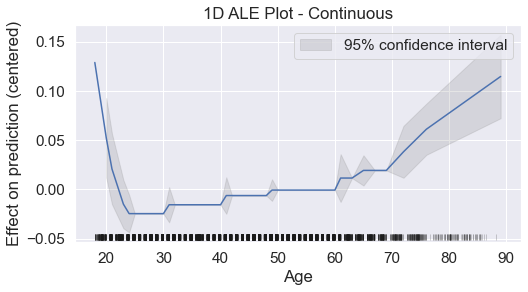

PyALE._ALE_generic:INFO: Continuous feature detected.


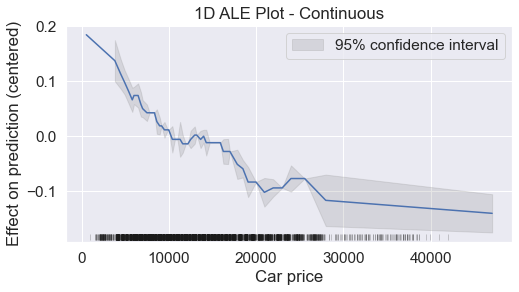

PyALE._ALE_generic:INFO: Continuous feature detected.


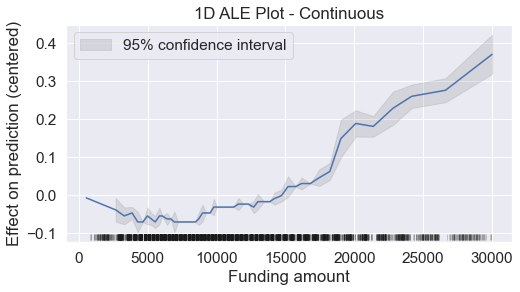

PyALE._ALE_generic:INFO: Discrete feature detected.


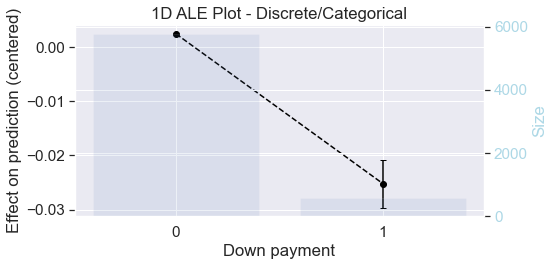

PyALE._ALE_generic:INFO: Continuous feature detected.


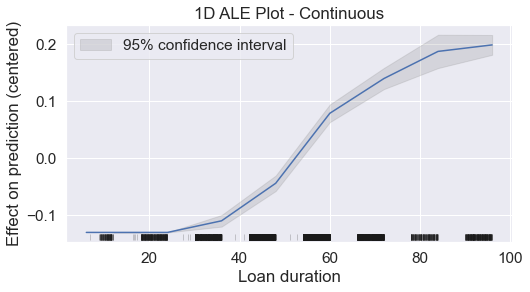

PyALE._ALE_generic:INFO: Continuous feature detected.


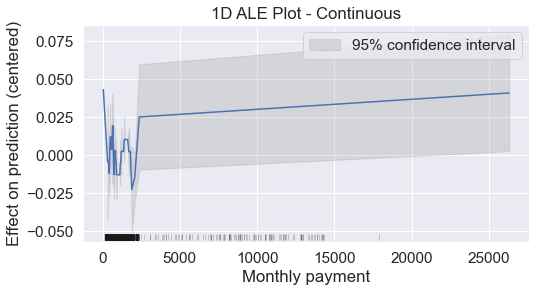

PyALE._ALE_generic:INFO: Discrete feature detected.


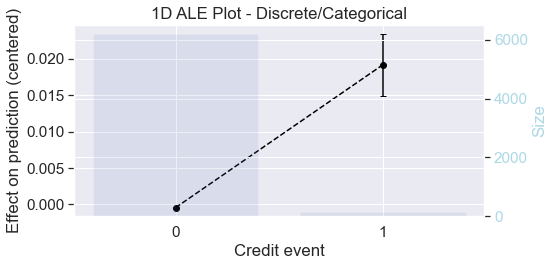

PyALE._ALE_generic:INFO: Discrete feature detected.


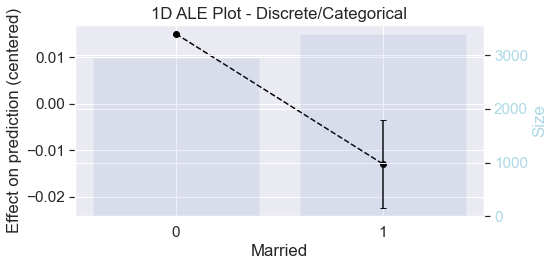

PyALE._ALE_generic:INFO: Discrete feature detected.


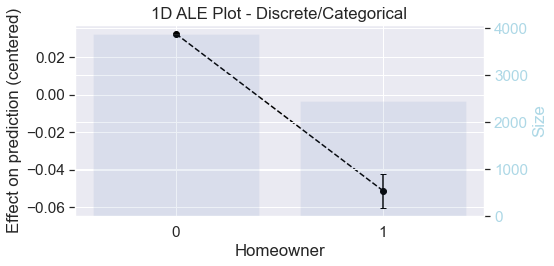

In [20]:
plot_ale(X_train, model)

#### Interpretation of the ALE : 
- Job tenure... 

## Local interpretability

### LIME 

LIME explains the prediction of any model by learning from an interpretable model locally around the prediction.

In [36]:
display_lime(X_train, model, X_train.index[20] )

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



#### Interpretation of LIME : 

### SHAP

The Shapley value of the feature xj is 
    the weighted average contribution of xj across all possible subsets S, 
    where S does not include xj.

In [37]:
explainer = shap.TreeExplainer(model)

choosen_instance = X_train.iloc[21, :]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)


#### Interpretation of shap : 